In [1]:
import pandas as pd

alcohol = pd.read_csv('1_alcohol.csv')
cancer = pd.read_csv('1_cancer.csv')
life_expectancy = pd.read_csv('1_life_expectancy.csv')
pollution = pd.read_csv('1_pollution.csv')

emissions = pd.read_csv('2_emissions.csv')

suicide = pd.read_csv('3_suicide.csv')

In [2]:
alcohol = alcohol.loc[alcohol['Dim1'] == 'Both sexes']
alcohol = alcohol.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
alcohol.rename(columns={'First Tooltip': 'Alcohol consumption', 'Location': 'Country'}, inplace=True)
alcohol = alcohol.drop('Indicator', axis=1)
alcohol

,Country,Alcohol consumption
0,Afghanistan,0.2100
1,Albania,7.1640
2,Algeria,0.7840
3,Andorra,11.7940
4,Angola,6.1420
...,...,...
183,Venezuela (Bolivarian Republic of),7.6400
184,Viet Nam,5.2520
185,Yemen,0.2832
186,Zambia,5.3620


In [3]:
cancer = cancer.loc[cancer['Dim1'] == 'Both sexes']
cancer = cancer.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
cancer.rename(columns={'First Tooltip': 'Probability (%) of cancer death >30 <70 years', 'Location': 'Country'}, inplace=True)
cancer = cancer.drop('Indicator', axis=1)
cancer

,Country,Probability (%) of cancer death >30 <70 years
0,Afghanistan,31.96
1,Albania,18.24
2,Algeria,16.54
3,Angola,19.36
4,Antigua and Barbuda,22.36
...,...,...
179,Venezuela (Bolivarian Republic of),19.14
180,Viet Nam,17.88
181,Yemen,31.78
182,Zambia,20.02


In [4]:
life_expectancy = life_expectancy.loc[life_expectancy['Dim1'] == 'Both sexes']
life_expectancy = life_expectancy.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
life_expectancy.rename(columns={'First Tooltip': 'Life expectancy', 'Location': 'Country'}, inplace=True)
life_expectancy = life_expectancy.drop('Indicator', axis=1)
life_expectancy

,Country,Life expectancy
0,Afghanistan,59.9475
1,Albania,76.4100
2,Algeria,75.4325
3,Angola,58.0375
4,Antigua and Barbuda,75.7750
...,...,...
179,Venezuela (Bolivarian Republic of),74.3725
180,Viet Nam,72.7675
181,Yemen,66.1225
182,Zambia,56.0200


In [5]:
pollution = pollution.loc[(pollution['Dim1'] == 'Both sexes') & (pollution['Dim2'] == 'Total')]
pollution = pollution.loc[pollution['Indicator'] == 'Ambient and household air pollution attributable death rate (per 100 000 population)']
pollution['First Tooltip'] = pollution['First Tooltip'].apply(lambda x: float(str(x).split(' [')[0]))
pollution = pollution.drop('Dim2', axis=1).drop('Dim1', axis=1).drop('Period', axis=1)
pollution = pollution.drop('Indicator', axis=1)
pollution = pollution.reset_index().drop('index', axis=1)
pollution.rename(columns={'Location': 'Country', 'First Tooltip': 'Pollution Death rate'}, inplace=True)

In [6]:
emissions = emissions.drop(emissions.columns.difference(['Country','Fossil CO2 emissions(Mt CO2)']), axis=1)

In [7]:
emissions

,Country,Fossil CO2 emissions(Mt CO2)
0,NaN,1990.000
1,World,22674.116
2,World International Aviation,258.941
3,World International Shipping,371.804
4,Afghanistan,2.546
...,...,...
208,Vietnam,20.182
209,Western Sahara,0.144
210,Yemen,6.887
211,Zambia,2.955


In [8]:
suicide['suicide_mean'] = suicide.iloc[:, 1:].mean(axis=1)
suicide = suicide.drop(suicide.columns.difference(['Country','mean_per_years']), axis=1)

In [9]:
suicide

,Country
0,Afghanistan *
1,Albania
2,Algeria
3,Angola
4,Antigua and Barbuda
...,...
178,Venezuela
179,Vietnam
180,Yemen
181,Zambia


In [10]:
final = pd.merge(alcohol, cancer, on='Country', how='inner')
final = pd.merge(final, life_expectancy, on='Country', how='inner')
final = pd.merge(final, pollution, on='Country', how='inner')
final = pd.merge(final, emissions, on='Country', how='inner')
final = pd.merge(final, suicide, on='Country', how='inner')
final

,Country,Alcohol consumption,Probability (%) of cancer death >30 <70 years,Life expectancy,Pollution Death rate,Fossil CO2 emissions(Mt CO2)
0,Albania,7.1640,18.24,76.4100,104.70,6.583
1,Algeria,0.7840,16.54,75.4325,40.33,65.677
2,Angola,6.1420,19.36,58.0375,67.25,5.851
3,Antigua and Barbuda,5.6740,22.36,75.7750,28.29,0.223
4,Argentina,9.1400,17.84,75.5700,36.95,112.434
...,...,...,...,...,...,...
121,Uzbekistan,3.6040,27.00,69.9800,54.10,123.106
122,Vanuatu,1.6920,25.08,64.5925,75.76,0.130
123,Yemen,0.2832,31.78,66.1225,89.75,6.887
124,Zambia,5.3620,20.02,56.0200,63.39,2.955


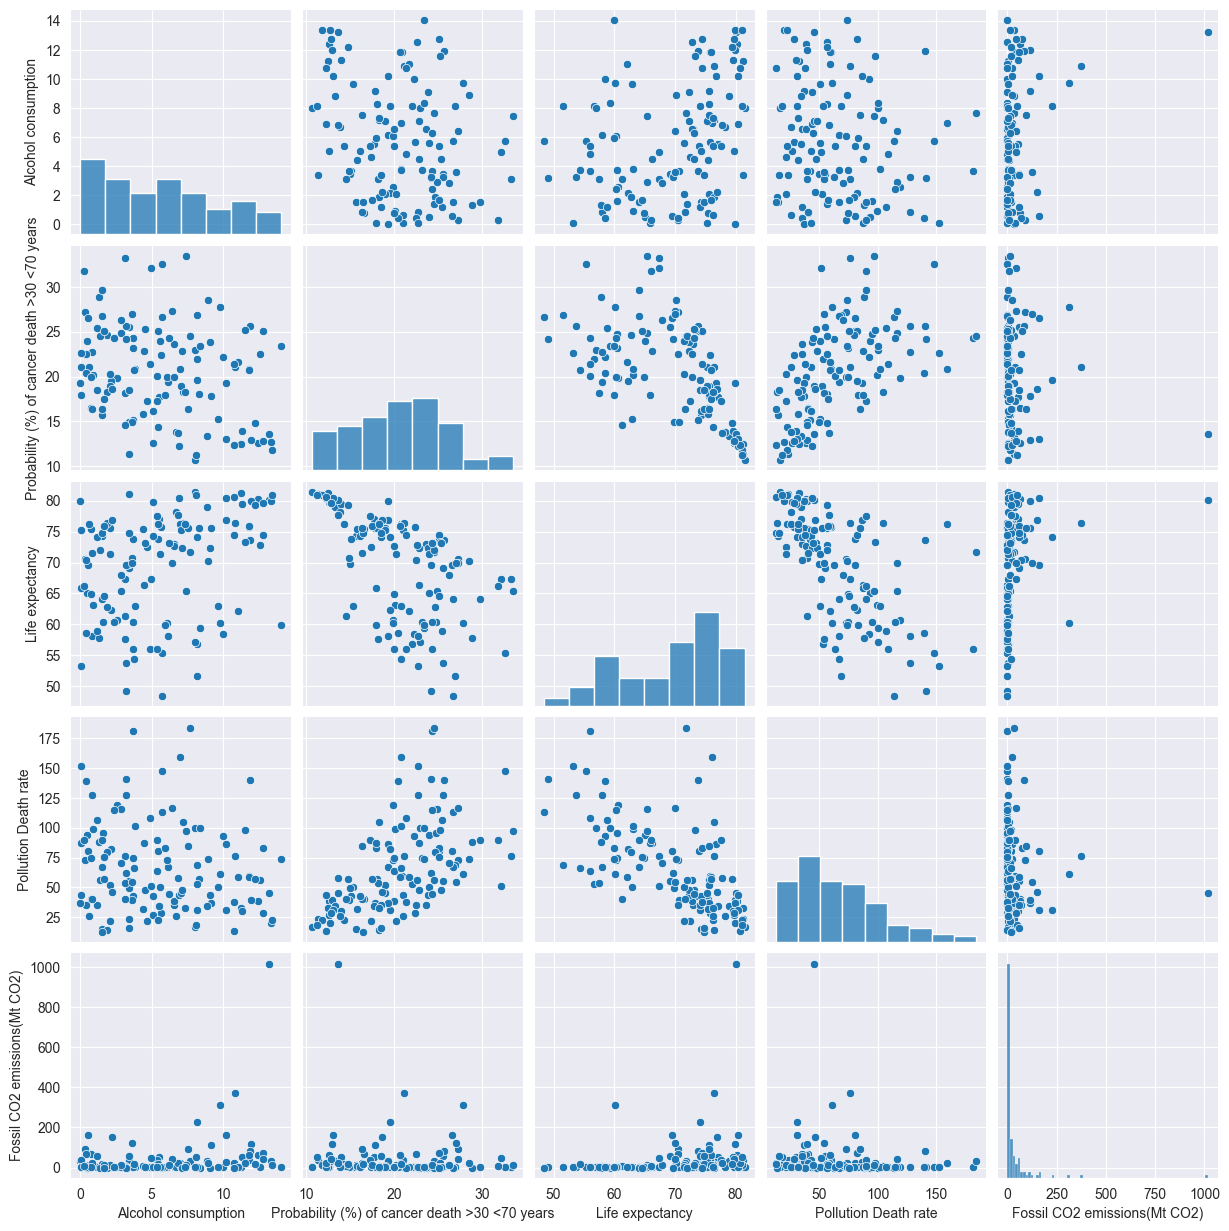

In [12]:
import seaborn as sns
sns.set_style("darkgrid")
sns.pairplot(final);